# XGBoost Forecasting with Nixtla's MLForecast

## Dataset: KaggleWPGD

This notebook demonstrates how to use the XGBoost forecasting model
with the implementation provided by Nixtla's MLForecast library:

## Important note:

This notebook uses the following conda environments:

+ Under linux: tfm_cc, described in the tfm_cc.yml file (see environments folder).
+ Under macOS: tfm_cc_nixtla, described in the tfm_cc_nixtla.yml file (see environments folder). 

## Execution Notes:

The run times that appear below correspond to the execution of the notebook in a Mac M2 machine, 16GB of RAM.

## Load basic libraries

**Warning:** Model specific libraries will be loaded below.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import logging



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



## Load dataset

The data in this notebook comes from the Kaggle dataset:

[Wind Power Generation Data - Forecasting](https://www.kaggle.com/datasets/mubashirrahim/wind-power-generation-data-forecasting/data)

In [51]:
file_path = "../../data/kaggleWPGD/Location1.csv"
df = pd.read_csv(file_path, delimiter=',')
df.head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


### Set datetime format and index

In [52]:
df['time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:00')
df.drop(columns=['Time'], inplace=True)
df.set_index('time', inplace=True)
df.head()

,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
time,,,,,,,,,
2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2017-01-02 00:00:00 to 2021-12-31 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature_2m       43800 non-null  float64
 1   relativehumidity_2m  43800 non-null  int64  
 2   dewpoint_2m          43800 non-null  float64
 3   windspeed_10m        43800 non-null  float64
 4   windspeed_100m       43800 non-null  float64
 5   winddirection_10m    43800 non-null  int64  
 6   winddirection_100m   43800 non-null  int64  
 7   windgusts_10m        43800 non-null  float64
 8   Power                43800 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 3.3 MB


### Select a subset of the data


In [54]:
df = df.head(7248)

### Rename the columns

In [55]:
initial_columns = df.columns.tolist()
initial_columns

['temperature_2m',
 'relativehumidity_2m',
 'dewpoint_2m',
 'windspeed_10m',
 'windspeed_100m',
 'winddirection_10m',
 'winddirection_100m',
 'windgusts_10m',
 'Power']

In [56]:
df.rename(columns={'Power' : 'Active_Power', 'windspeed_10m' : 'Wind_speed_tower'}, inplace=True)
df = df[['Active_Power', 'Wind_speed_tower']]
df

,Active_Power,Wind_speed_tower
time,,
2017-01-02 00:00:00,0.1635,1.44
2017-01-02 01:00:00,0.1424,2.06
2017-01-02 02:00:00,0.1214,1.30
2017-01-02 03:00:00,0.1003,1.30
2017-01-02 04:00:00,0.0793,2.47
...,...,...
2017-10-30 19:00:00,0.6847,5.89
2017-10-30 20:00:00,0.6841,6.32
2017-10-30 21:00:00,0.6834,6.52


### Check for missing values and duplicated dates

There are no missing data in this dataset

In [57]:
print(df.isna().sum())

Active_Power        0
Wind_speed_tower    0
dtype: int64


In [58]:
duplicate_dates = df.index[df.index.duplicated(keep='first')]
print(f"Number of duplicate timestamps: {len(duplicate_dates)}")
print(duplicate_dates)

Number of duplicate timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)


In [59]:
expected = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing = expected.difference(df.index)
print("Missing timestamps:", missing)



Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='h')


In [60]:
missing_df = pd.DataFrame({'missing':missing})
missing_df['date'] = missing_df['missing'].dt.date
missing_df.value_counts('date').sort_index()

Series([], Name: count, dtype: int64)

### Target and exogenous variables

In [61]:
target = 'Active_Power'

features = [col for col in df.columns if col != target]
features = features[:1]
features


['Wind_speed_tower']

In [62]:
df = df[features + [target]]
df

,Wind_speed_tower,Active_Power
time,,
2017-01-02 00:00:00,1.44,0.1635
2017-01-02 01:00:00,2.06,0.1424
2017-01-02 02:00:00,1.30,0.1214
2017-01-02 03:00:00,1.30,0.1003
2017-01-02 04:00:00,2.47,0.0793
...,...,...
2017-10-30 19:00:00,5.89,0.6847
2017-10-30 20:00:00,6.32,0.6841
2017-10-30 21:00:00,6.52,0.6834


## Train / Validation / Test split

We select the following lengths for the train, validation, and test sets:

In [63]:
int(np.ceil(df.shape[0] * 0.8))

5799

In [64]:
train_len = 5800 # approx int(np.ceil(df.shape[0] * 0.8))
print(f"Train length: {train_len}")

val_len = (df.shape[0] - train_len) // 2
print(f"Validation length: {val_len}")

test_len = df.shape[0] - train_len - val_len
print(f"Test length: {test_len}")

Train length: 5800
Validation length: 724
Test length: 724


And we split the time series into train, validation, and test sets:

In [65]:
train_df = df.iloc[:train_len]
train_df

,Wind_speed_tower,Active_Power
time,,
2017-01-02 00:00:00,1.44,0.1635
2017-01-02 01:00:00,2.06,0.1424
2017-01-02 02:00:00,1.30,0.1214
2017-01-02 03:00:00,1.30,0.1003
2017-01-02 04:00:00,2.47,0.0793
...,...,...
2017-08-31 11:00:00,4.83,0.6155
2017-08-31 12:00:00,5.15,0.5935
2017-08-31 13:00:00,5.47,0.5536


In [66]:
val_df = df.iloc[train_len:(train_len + val_len)]
val_df

,Wind_speed_tower,Active_Power
time,,
2017-08-31 16:00:00,5.87,0.4339
2017-08-31 17:00:00,5.19,0.3940
2017-08-31 18:00:00,4.26,0.3605
2017-08-31 19:00:00,2.21,0.3334
2017-08-31 20:00:00,2.55,0.3063
...,...,...
2017-09-30 15:00:00,2.12,0.0907
2017-09-30 16:00:00,2.42,0.0991
2017-09-30 17:00:00,2.10,0.1076


In [67]:
test_df = df.iloc[(train_len + val_len):]
test_df

,Wind_speed_tower,Active_Power
time,,
2017-09-30 20:00:00,1.80,0.1357
2017-09-30 21:00:00,1.71,0.1453
2017-09-30 22:00:00,1.44,0.1548
2017-09-30 23:00:00,1.40,0.1644
2017-10-01 00:00:00,2.20,0.1739
...,...,...
2017-10-30 19:00:00,5.89,0.6847
2017-10-30 20:00:00,6.32,0.6841
2017-10-30 21:00:00,6.52,0.6834


## Time series split visualization

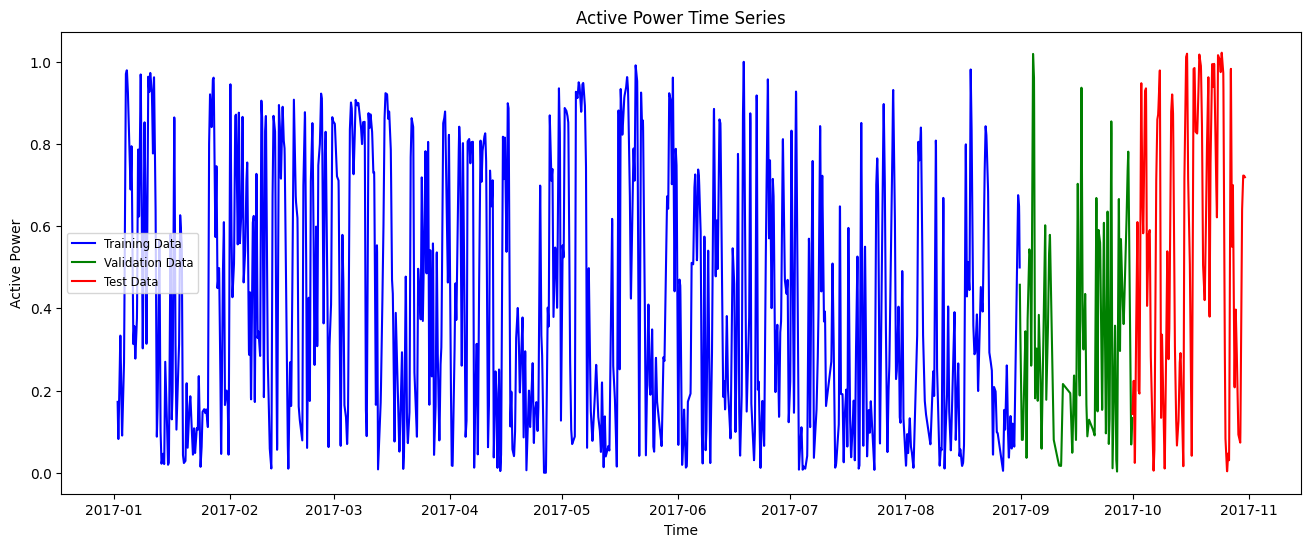

In [114]:
plt.figure(figsize=(16, 6))
plt.plot(train_df["Active_Power"], label="Training Data", color='blue')
plt.plot(val_df["Active_Power"], label="Validation Data", color='green')
plt.plot(test_df["Active_Power"], label="Test Data", color='red')
plt.title("Active Power Time Series")
plt.xlabel("Time")
plt.ylabel("Active Power")
plt.legend(fontsize='small')
plt.show();plt.close()

We will also create copies of the train, validation, and test sets to use them later in the notebook.

In [69]:
train_df_original = train_df.copy()
val_df_original = val_df.copy()
test_df_original = test_df.copy()

## Data scaling

We apply the min-max scaler fitted to the training set to the train, validation, and test sets (to avoid data leakage). 

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.set_output(transform='pandas')

scaler.fit(train_df)
train_df = scaler.transform(train_df)

val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

Let us check the result

In [71]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wind_speed_tower,5800.0,0.275745,0.127310,0.0,0.184488,0.249247,0.348645,1.0
Active_Power,5800.0,0.407862,0.287194,0.0,0.149394,0.349394,0.669188,1.0


### Nixtla Dataset Format

Convert to NeuralForecast format (ds, y, unique_id)

In [72]:


train_df_nf = train_df.copy()
train_df_nf = train_df_nf.rename(columns={target: 'y'})
train_df_nf['ds'] = train_df_nf.index

train_df_nf['unique_id'] = 'series_1'


Move ds and unique_id to front

In [73]:

train_df_nf = train_df_nf[['unique_id', 'ds', 'y'] + features]
train_df_nf


,unique_id,ds,y,Wind_speed_tower
time,,,,
2017-01-02 00:00:00,series_1,2017-01-02 00:00:00,0.172377,0.108434
2017-01-02 01:00:00,series_1,2017-01-02 01:00:00,0.150132,0.155120
2017-01-02 02:00:00,series_1,2017-01-02 02:00:00,0.127992,0.097892
2017-01-02 03:00:00,series_1,2017-01-02 03:00:00,0.105746,0.097892
2017-01-02 04:00:00,series_1,2017-01-02 04:00:00,0.083606,0.185994
...,...,...,...,...
2017-08-31 11:00:00,series_1,2017-08-31 11:00:00,0.648919,0.363705
2017-08-31 12:00:00,series_1,2017-08-31 12:00:00,0.625725,0.387801
2017-08-31 13:00:00,series_1,2017-08-31 13:00:00,0.583658,0.411898


Same for validation and test sets

In [74]:
val_df_nf = val_df.copy()
val_df_nf = val_df_nf.rename(columns={target: 'y'})
val_df_nf['ds'] = val_df_nf.index

val_df_nf['unique_id'] = 'series_1'

val_df_nf = val_df_nf[['unique_id', 'ds', 'y'] + features]
val_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2017-08-31 16:00:00,series_1,2017-08-31 16:00:00,0.457459,0.442018
2017-08-31 17:00:00,series_1,2017-08-31 17:00:00,0.415393,0.390813
2017-08-31 18:00:00,series_1,2017-08-31 18:00:00,0.380074,0.320783
2017-08-31 19:00:00,series_1,2017-08-31 19:00:00,0.351502,0.166416
2017-08-31 20:00:00,series_1,2017-08-31 20:00:00,0.322931,0.192018
...,...,...,...,...
2017-09-30 15:00:00,series_1,2017-09-30 15:00:00,0.095625,0.159639
2017-09-30 16:00:00,series_1,2017-09-30 16:00:00,0.104481,0.182229
2017-09-30 17:00:00,series_1,2017-09-30 17:00:00,0.113442,0.158133


In [75]:
test_df_nf = test_df.copy()
test_df_nf = test_df_nf.rename(columns={target: 'y'})
test_df_nf['ds'] = test_df_nf.index

test_df_nf['unique_id'] = 'series_1'

test_df_nf = test_df_nf[['unique_id', 'ds', 'y'] + features]
test_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2017-09-30 20:00:00,series_1,2017-09-30 20:00:00,0.143068,0.135542
2017-09-30 21:00:00,series_1,2017-09-30 21:00:00,0.153189,0.128765
2017-09-30 22:00:00,series_1,2017-09-30 22:00:00,0.163205,0.108434
2017-09-30 23:00:00,series_1,2017-09-30 23:00:00,0.173326,0.105422
2017-10-01 00:00:00,series_1,2017-10-01 00:00:00,0.183342,0.165663
...,...,...,...,...
2017-10-30 19:00:00,series_1,2017-10-30 19:00:00,0.721877,0.443524
2017-10-30 20:00:00,series_1,2017-10-30 20:00:00,0.721244,0.475904
2017-10-30 21:00:00,series_1,2017-10-30 21:00:00,0.720506,0.490964


Create a joint dataset with train and validation to fit into Nixtla's framework.

In [76]:
train_val_df = pd.concat([train_df_nf, val_df_nf], axis=0)
train_val_df.reset_index(drop=True, inplace=True)
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6524 entries, 0 to 6523
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         6524 non-null   object        
 1   ds                6524 non-null   datetime64[ns]
 2   y                 6524 non-null   float64       
 3   Wind_speed_tower  6524 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 204.0+ KB


And similarly a full dataset with train, validation and test sets.

In [77]:
full_df_nf = pd.concat([train_df_nf, val_df_nf, test_df_nf], axis=0)
full_df_nf.reset_index(drop=True, inplace=True)
full_df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         7248 non-null   object        
 1   ds                7248 non-null   datetime64[ns]
 2   y                 7248 non-null   float64       
 3   Wind_speed_tower  7248 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 226.6+ KB


## Set the forecast horizon and input length

In [78]:
horizon = 3
input_size = 6

# XGBoost

Let us load the required libraries for the XGBoost model.

In [119]:
from mlforecast import MLForecast
from mlforecast.auto import AutoModel, AutoXGBoost, AutoMLForecast

import optuna

import xgboost as xgb



In [118]:
# train_val_df.tail(10)

We create a dictionary to store the predictions of the XGBoost models for each prediction horizon.

In [81]:
preds_df = {}

And another one to store the fitted models and their parameters

In [ ]:
xgb_dict = {}

Next we create a function that will define the hyperparameter grid for the Optuna optimization process of the XGBoost models.

In [82]:
def xgb_forecasting_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'random_state': 42,
        'tree_method': 'hist',  # more efficient for large datasets
        'verbosity': 0
    }

In [ ]:
%%capture --no-stderr --no-display

start_time = time.time()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.getLogger("lightning_fabric.utilities.seed").setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.ERROR)

# The following loop processes each horizon from 1 to the maximum specified horizon value.
for h in range(1, horizon + 1):
# for h in range(1, 2):

    # Initialize the dictionary to store models and parameters for each horizon
    xgb_dict[f'{h}h'] = {}

    print(f"Processing horizon: {h}h")

    # Create a copy of the full DataFrame for the current horizon
    full_df_nf_h = full_df_nf.copy()

    # Create the target variable by shifting the 'y' column by 'h' hours into the future (negative lags)
    full_df_nf_h['h_target'] = full_df_nf_h['y'].shift(-h)
    
    # Also create lagged features for the 'Wind_speed_tower' column
    # making sure that each model only has access to past values of wind
    for k in range(1, horizon + 1):
        full_df_nf_h[f'Wind_speed_tower_lag{k}'] = full_df_nf_h['Wind_speed_tower'].shift(k)

    # Remove the non-lagged columns and rename the target column
    full_df_nf_h.drop(columns=['y', 'Wind_speed_tower'], inplace=True)
    full_df_nf_h.rename(columns={'h_target': 'y'}, inplace=True)
    
    # Select the data corresponding to the train and validation sets
    train_val_df_h = full_df_nf_h.head(train_val_df.shape[0]).copy()

    # Use init_config to pass the lags of the target variable to the auto model
    def my_init_config(trial: optuna.Trial):
        return {
            'lags': range(1 + h, input_size + 1 + h)
        }
        
    # Use fit_config to indicate that all the features (Wind) are dynamic features
    def my_fit_config(trial: optuna.Trial):    
        return {
            'static_features': []
        }

    # Now define an auto model for XGBoost with the specified configurations
    auto_xgb = AutoMLForecast(
        models={'xgb': AutoXGBoost()},
        freq='H',
        init_config=my_init_config,
        fit_config=my_fit_config,
        num_threads=1)
    
    # Fit the model on the training and validation data (Optuna optimized)
    auto_xgb.fit(train_val_df_h,
                 h = 1,
                 num_samples= 20,
                 n_windows=10)


    # Get optimal parameters, and store the model
    xgb_dict[f'{h}h']['model'] = auto_xgb.models['xgb'].model
    xgb_dict[f'{h}h']['best_params'] = auto_xgb.results_['xgb'].best_params

    # Now use that optimized model (as a regular model) to make predictions
    # These are **one-step-ahead predictions of the future-lagged output**
    fcst = MLForecast(
        models=[xgb_dict[f'{h}h']['model']],
        freq='H',
        lags=range(1 + h, input_size + 1 + h),  
        num_threads=1)
        
    # The value of n moves across the test set, predicting one step at a time
    # We use the first row (n = 0) of the test set to initialize the output DataFrame
    n = 0 

    # This is the data used for the 0-th prediction
    train_val_df_h_n = full_df_nf_h.head(train_val_df.shape[0] + n).copy()

    # Fit the optimal model to that data
    fcst.fit(train_val_df_h_n, static_features=[])

    # Also define the X_df DataFrame, which contains the features for the 0-th prediction
    X_df=full_df_nf_h.head(train_val_df_h_n.shape[0] + 1).drop(columns=['y'])

    # Predict and use the predictions to initialize the output DataFrame
    preds_df[f'{h}h'] = fcst.predict(h = 1, X_df=X_df)
    
    # This loop iterates over the remaining rows of the test set, predicting one step at a time
    # using the same steps
    for n in range(1, test_df_nf.shape[0] - h + 1):
        # Data for n-th row
        train_val_df_h_n = full_df_nf_h.head(train_val_df.shape[0] + n).copy()
        # Fit the model to the data for n-th row
        fcst.fit(train_val_df_h_n, static_features=[])
        # Define the X_df DataFrame for the n-th prediction
        X_df = full_df_nf_h.head(train_val_df_h_n.shape[0] + n).drop(columns=['y'])
        # Predict the next step using the fitted model and the X_df DataFrame
        # and concatenate the predictions to the output DataFrame
        preds_df[f'{h}h'] = pd.concat([preds_df[f'{h}h'], fcst.predict(h = 1, X_df=X_df)], axis=0)
 

    # When the predictions are done, we rename the columns and set the index
    preds_df[f'{h}h'].rename(columns={'XGBRegressor': f'pred_{h}h'}, inplace=True)
    preds_df[f'{h}h'].set_index('ds', inplace=True)

end_time = time.time()
elapsed_time = end_time - start_time


In [ ]:
print(f"Elapsed time: {elapsed_time / 60:.2f} minutes")

Let us take a look at the hyperparameter selected by Optuna for the XGBoost models for each prediction horizon.

In [120]:
xgb_dict['1h']['best_params']

{'n_estimators': 372,
 'max_depth': 5,
 'learning_rate': 0.040296776607459256,
 'subsample': 0.15420292446634284,
 'colsample_bytree': 0.700090043901101,
 'reg_lambda': 0.002317944093186113,
 'reg_alpha': 4.820149280505929e-07,
 'min_child_weight': 3}

In [121]:
xgb_dict['2h']['best_params']

{'n_estimators': 694,
 'max_depth': 7,
 'learning_rate': 0.018032874318828725,
 'subsample': 0.37015182697338095,
 'colsample_bytree': 0.7079907203542237,
 'reg_lambda': 1.09689218247655e-08,
 'reg_alpha': 9.077275833621343e-06,
 'min_child_weight': 6}

In [116]:
xgb_dict['3h']['best_params']

{'n_estimators': 262,
 'max_depth': 10,
 'learning_rate': 0.01830957539375179,
 'subsample': 0.8711861931788317,
 'colsample_bytree': 0.6342927711041051,
 'reg_lambda': 0.004195102168027593,
 'reg_alpha': 5.442505599655872e-06,
 'min_child_weight': 7}

# Model Performance Evaluation

Let us also look at the prediction dataframes for the XGBoost models for each prediction horizon.

In [ ]:
preds_df['1h']

,unique_id,pred_1h
ds,,
2017-09-30 20:00:00,series_1,0.155094
2017-09-30 21:00:00,series_1,0.163852
2017-09-30 22:00:00,series_1,0.168162
2017-09-30 23:00:00,series_1,0.189998
2017-10-01 00:00:00,series_1,0.195466
...,...,...
2017-10-30 19:00:00,series_1,0.713319
2017-10-30 20:00:00,series_1,0.715375
2017-10-30 21:00:00,series_1,0.717366


In [ ]:
preds_df['2h']

,unique_id,pred_2h
ds,,
2017-09-30 20:00:00,series_1,0.155557
2017-09-30 21:00:00,series_1,0.170095
2017-09-30 22:00:00,series_1,0.162096
2017-09-30 23:00:00,series_1,0.193209
2017-10-01 00:00:00,series_1,0.194572
...,...,...
2017-10-30 18:00:00,series_1,0.694724
2017-10-30 19:00:00,series_1,0.695877
2017-10-30 20:00:00,series_1,0.685921


In [ ]:
preds_df['3h']

,unique_id,pred_3h
ds,,
2017-09-30 20:00:00,series_1,0.177818
2017-09-30 21:00:00,series_1,0.179062
2017-09-30 22:00:00,series_1,0.171251
2017-09-30 23:00:00,series_1,0.190027
2017-10-01 00:00:00,series_1,0.184554
...,...,...
2017-10-30 17:00:00,series_1,0.694885
2017-10-30 18:00:00,series_1,0.670041
2017-10-30 19:00:00,series_1,0.713533


And let us plot the predictions of the XGBoost models for each prediction horizon.

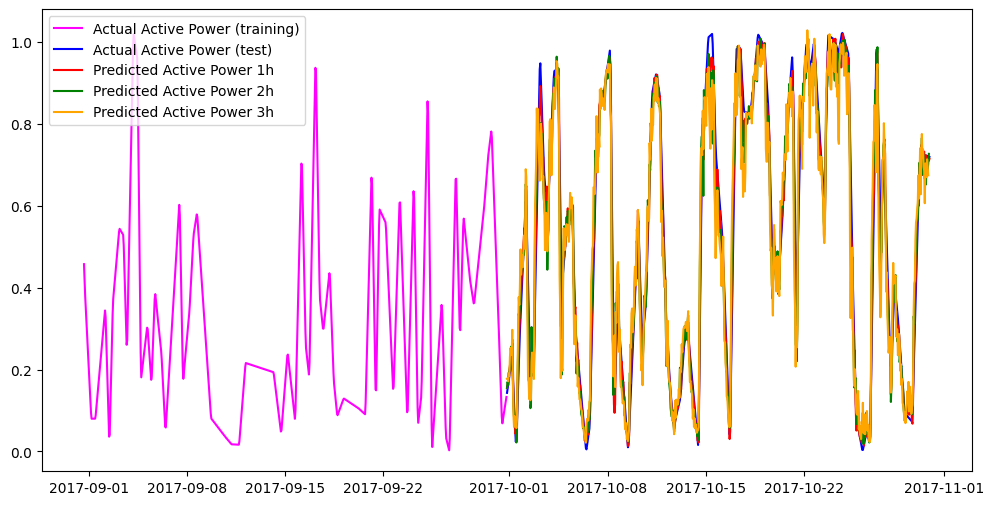

In [122]:
%matplotlib inline

plt.figure(figsize=(12, 6))
plt.plot(val_df_nf["y"], label="Actual Active Power (training)", color='magenta')
plt.plot(test_df_nf["y"], label="Actual Active Power (test)", color='blue')
for h in range(1, horizon + 1):
    colors = ['red', 'green', 'orange', 'purple', 'brown', 'cyan']
    plt.plot(
        preds_df[f'{h}h'][f'pred_{h}h'],
        label=f"Predicted Active Power {h}h",
        color=colors[(h - 1) % len(colors)]
    )
plt.legend()
plt.show();plt.close()


### MAE computation

We will next compute the MAE for each of the predictions in the dictionary. 

In [94]:
from sklearn.metrics import mean_absolute_error

#### Mae for 1h preddictions

In [99]:
mae1h_df = preds_df['1h'].copy()[['pred_1h']]
mae1h_df


,pred_1h
ds,
2017-09-30 20:00:00,0.155094
2017-09-30 21:00:00,0.163852
2017-09-30 22:00:00,0.168162
2017-09-30 23:00:00,0.189998
2017-10-01 00:00:00,0.195466
...,...
2017-10-30 19:00:00,0.713319
2017-10-30 20:00:00,0.715375
2017-10-30 21:00:00,0.717366


We need to add the exogenous variables as they were used by the scaler. 

In [100]:
mae1h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values)
mae1h_df

,Wind_speed_tower,pred_1h
ds,,
2017-09-30 20:00:00,0.135542,0.155094
2017-09-30 21:00:00,0.128765,0.163852
2017-09-30 22:00:00,0.108434,0.168162
2017-09-30 23:00:00,0.105422,0.189998
2017-10-01 00:00:00,0.165663,0.195466
...,...,...
2017-10-30 19:00:00,0.443524,0.713319
2017-10-30 20:00:00,0.475904,0.715375
2017-10-30 21:00:00,0.490964,0.717366


In [101]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae1h_df)[:,1], test_df_original["Active_Power"])

0.027960592472690768

#### Mae for 2h preddictions

In [104]:
mae2h_df = preds_df['2h'].copy()[['pred_2h']]
mae2h_df


,pred_2h
ds,
2017-09-30 20:00:00,0.155557
2017-09-30 21:00:00,0.170095
2017-09-30 22:00:00,0.162096
2017-09-30 23:00:00,0.193209
2017-10-01 00:00:00,0.194572
...,...
2017-10-30 18:00:00,0.694724
2017-10-30 19:00:00,0.695877
2017-10-30 20:00:00,0.685921


In [105]:
mae2h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-1])
mae2h_df

,Wind_speed_tower,pred_2h
ds,,
2017-09-30 20:00:00,0.135542,0.155557
2017-09-30 21:00:00,0.128765,0.170095
2017-09-30 22:00:00,0.108434,0.162096
2017-09-30 23:00:00,0.105422,0.193209
2017-10-01 00:00:00,0.165663,0.194572
...,...,...
2017-10-30 18:00:00,0.476657,0.694724
2017-10-30 19:00:00,0.443524,0.695877
2017-10-30 20:00:00,0.475904,0.685921


In [110]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae2h_df)[:,1], test_df_original["Active_Power"][:-1])

0.047820639583508885

#### Mae for 3h preddictions

In [111]:
mae3h_df = preds_df['3h'].copy()[['pred_3h']]
mae3h_df


,pred_3h
ds,
2017-09-30 20:00:00,0.177818
2017-09-30 21:00:00,0.179062
2017-09-30 22:00:00,0.171251
2017-09-30 23:00:00,0.190027
2017-10-01 00:00:00,0.184554
...,...
2017-10-30 17:00:00,0.694885
2017-10-30 18:00:00,0.670041
2017-10-30 19:00:00,0.713533


In [112]:
mae3h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-2])
mae3h_df

,Wind_speed_tower,pred_3h
ds,,
2017-09-30 20:00:00,0.135542,0.177818
2017-09-30 21:00:00,0.128765,0.179062
2017-09-30 22:00:00,0.108434,0.171251
2017-09-30 23:00:00,0.105422,0.190027
2017-10-01 00:00:00,0.165663,0.184554
...,...,...
2017-10-30 17:00:00,0.443524,0.694885
2017-10-30 18:00:00,0.476657,0.670041
2017-10-30 19:00:00,0.443524,0.713533


In [113]:
mean_absolute_error(scaler.inverse_transform(mae3h_df)[:,1], test_df_original["Active_Power"][:-2])

0.06636662053759353